In [1]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import line_profiler

import datetime

from io import StringIO
from pandas.api.types import CategoricalDtype

import pandas._testing as tm

## returns df from string data
def g(data):
    return pd.read_csv(StringIO(data))

# 2.16.1 Statistical functions

In [5]:
ser = pd.Series(np.random.randn(8))
ser.pct_change()

0         NaN
1   -1.923373
2   -2.931038
3   -0.935503
4   -0.123427
5    7.136023
6   -1.639340
7   -2.450775
dtype: float64

In [7]:
df = DataFrame(np.random.rand(10, 4))
df.pct_change(3)

,0,1,2,3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,-0.020591,12.475995,0.967325,-0.553468
4,1.522533,-0.759493,4.268283,-0.128637
5,-0.839266,4.969317,-0.877771,-0.342039
6,-0.230832,0.994627,-0.320743,1.306429
7,0.511824,3.978803,2.442230,-0.767423
8,1.038695,14.972710,17.444836,0.235789
9,-0.085083,0.054706,0.009563,-0.911786


In [14]:
s = pd.Series(range(1,6))
print(s)
s.pct_change(3)

0    1
1    2
2    3
3    4
4    5
dtype: int64


0    NaN
1    NaN
2    NaN
3    3.0
4    1.5
dtype: float64

In [16]:
s1 = pd.Series(range(1,11))
s2 = pd.Series(range(2,21,2))
s1.cov(s2)

18.333333333333332

In [18]:
frame = pd.DataFrame(np.random.randn(1000, 5), columns=["a", "b", "c", "d", "e"])
frame.cov()

,a,b,c,d,e
a,1.050728,0.021590,-0.033379,0.031233,0.035940
b,0.021590,1.030669,0.022360,-0.035406,0.055048
c,-0.033379,0.022360,1.059442,0.056878,-0.038169
d,0.031233,-0.035406,0.056878,0.933382,0.052404
e,0.035940,0.055048,-0.038169,0.052404,0.895523


In [20]:
frame = pd.DataFrame(np.random.randn(20, 3), columns=["a", "b", "c"])
frame.loc[frame.index[:5], "a"] = np.nan
frame.loc[frame.index[5:10], "b"] = np.nan
frame.cov()
frame.cov(min_periods=12)

,a,b,c
a,0.969831,NaN,0.318122
b,NaN,0.937038,-0.037230
c,0.318122,-0.037230,0.880216


In [24]:
s1 = pd.Series(range(1,6))
s2 = pd.Series(range(6,11))
s2[:3] = np.nan
s1.cov(s2, min_periods=2)

0.5

In [26]:
frame = pd.DataFrame(np.random.randn(20, 3), columns=["a", "b", "c"])
frame.loc[frame.index[:5], "a"] = np.nan
frame.loc[frame.index[5:10], "b"] = np.nan
frame.corr()
frame.corr(min_periods=12)

,a,b,c
a,1.000000,NaN,-0.268127
b,NaN,1.000000,-0.058104
c,-0.268127,-0.058104,1.000000


In [27]:
def histogram_intersection(a, b):
    return np.minimum(np.true_divide(a, a.sum()), 
                      np.true_divide(b, b.sum())).sum()

frame.corr(method=histogram_intersection)

,a,b,c
a,1.000000,-0.449048,-6.072194
b,-0.449048,1.000000,-0.541214
c,-6.072194,-0.541214,1.000000


In [28]:
index = ["a", "b", "c", "d", "e"]
columns = ["one", "two", "three", "four"]
df1 = pd.DataFrame(np.random.randn(5, 4), index=index, columns=columns)
df2 = pd.DataFrame(np.random.randn(4, 4), index=index[:4], columns=columns)

df1.corrwith(df2)

one      0.517229
two     -0.014314
three   -0.362604
four    -0.563880
dtype: float64

In [30]:
s = pd.Series(np.random.randn(5), index=list("abcde"))
s["d"] = s["b"] # so there's a tie
s.rank()

a    1.688946
b    1.489742
c   -0.845329
d    1.489742
e    0.695434
dtype: float64

In [31]:
s.rank()

a    5.0
b    3.5
c    1.0
d    3.5
e    2.0
dtype: float64

In [36]:
df = pd.DataFrame(np.random.randn(10, 6))
df[4] = df[2][:5] # some ties
df.rank(1, ascending=False)

,0,1,2,3,4,5
0,6.0,1.0,2.5,4.0,2.5,5.0
1,6.0,3.0,1.5,4.0,1.5,5.0
2,5.0,4.0,2.5,1.0,2.5,6.0
3,3.0,1.0,4.5,2.0,4.5,6.0
4,2.0,4.0,5.5,1.0,5.5,3.0
5,3.0,1.0,4.0,5.0,NaN,2.0
6,4.0,1.0,3.0,5.0,NaN,2.0
7,3.0,1.0,4.0,2.0,NaN,5.0
8,5.0,4.0,3.0,2.0,NaN,1.0
9,4.0,2.0,3.0,1.0,NaN,5.0


# Group by

## 2.17.1 Splitting an object into groups

In [2]:
df = pd.DataFrame([
    ("bird", "Falconiformes", 389.0),
    ("bird", "Psittaciformes", 24.0),
    ("mammal", "Carnivora", 80.2),
    ("mammal", "Primates", np.nan),
    ("mammal", "Carnivora", 58),
],
   index=["falcon", "parrot", "lion", "monkey", "leopard"],
   columns=("class", "order", "max_speed"), 
)
df


# default is axis=0
grouped = df.groupby('class')
grouped = df.groupby('order', axis='columns')
grouped = df.groupby(["class", "order"])

In [3]:
df = pd.DataFrame({
    "A": ["foo", "bar", "foo", "bar", "foo", "bar", "foo", "foo"],
    "B": ["one", "one", "two", "three", "two", "two", "one", "three"],
    "C": np.random.randn(8),
    "D": np.random.randn(8),
})
df

,A,B,C,D
0,foo,one,0.713989,-1.739929
1,bar,one,0.515902,1.747634
2,foo,two,1.560985,0.266590
3,bar,three,0.523009,-0.576076
4,foo,two,-0.257393,1.003956
5,bar,two,-0.547125,0.999715
6,foo,one,0.290983,2.337841
7,foo,three,-0.698266,1.651169


In [4]:
df2 = df.set_index(["A", "B"])
grouped = df2.groupby(df2.index.names.difference(["B"]))
grouped.sum()

,C,D
A,,
bar,0.491786,2.171272
foo,1.610298,3.519627


In [5]:
    def get_letter_type(letter):
        if letter.lower() in 'aeiou':
            return 'vowel'
        else:
            return 'consonant'
    df.groupby(get_letter_type, axis=1).apply(lambda x: x.values)

consonant    [[one, 0.713988569773656, -1.739928667366921],...
vowel        [[foo], [bar], [foo], [bar], [foo], [bar], [fo...
dtype: object

In [6]:
lst = [1, 2, 3, 1, 2, 3]
s = pd.Series([1, 2, 3, 10, 20, 30], lst)
grouped = s.groupby(level=0)
grouped.first()
grouped.last()
grouped.sum()

1    11
2    22
3    33
dtype: int64

In [7]:
df2 = pd.DataFrame({"X": ["B", "B", "A", "A"], "Y": [1, 2, 3, 4]})
df2.groupby('X', sort=False).sum()
df2.groupby('X').sum()

,Y
X,
A,7
B,3


In [8]:
df3 = pd.DataFrame({"X": ["A", "B", "A", "B"], "Y": [1, 4, 3, 2]})
df3.groupby('X').get_group('A')
df3.groupby('X').get_group('B')

,X,Y
1,B,4
3,B,2


In [9]:
df_list = [[1, 2, 3], [1, None, 4], [2, 1, 3], [1, 2, 2]]
df_dna = pd.DataFrame(df_list, columns=["a", "b", "c"])
df_dna

# Default ``dropna`` is set to True, which will exclude NaNs in keys
df_dna.groupby(by="b").sum()
df_dna.groupby(by="b", dropna=False).sum()

,a,c
b,,
1.0,2,3
2.0,2,5
NaN,1,4


In [10]:
df.groupby('A').groups

{'bar': [1, 3, 5], 'foo': [0, 2, 4, 6, 7]}

In [11]:
 df.groupby(get_letter_type, axis=1).groups

{'consonant': ['B', 'C', 'D'], 'vowel': ['A']}

In [12]:
df
grouped = df.groupby(['A','B'])
grouped.groups
len(grouped)

6

In [13]:
d="""date,height,weight,gender
2000-01-01,42.849980,157.500553,male
2000-01-02,49.607315,177.340407,male
2000-01-03,56.293531,171.524640,male
2000-01-04,48.421077,144.251986,female
2000-01-05,46.556882,152.526206,male
2000-01-06,68.448851,168.272968,female
2000-01-07,70.757698,136.431469,male
2000-01-08,58.909500,176.499753,female
2000-01-09,76.435631,174.094104,female
2000-01-10,45.306120,177.540920,male"""
df=g(d)
df['date'] = pd.to_datetime(df.date)
df = df.set_index('date')
gb = df.groupby('gender')
gb.<TAB>

SyntaxError: invalid syntax (<ipython-input-13-1bc1fbff6a1f>, line 16)

In [14]:
arrays = [
    ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
    ["one", "two", "one", "two", "one", "two", "one", "two"],
]
index = pd.MultiIndex.from_arrays(arrays, names=['first', 'second'])
s = pd.Series(np.random.rand(8), index=index)
s

# We can then group by one of the levels in s.
grouped = s.groupby(level=1)
grouped.sum()

# If the MultiIndex has names specified, these can be passed instead of the level number:
s.groupby(level='second').sum()


second
one    0.934844
two    1.331581
dtype: float64

In [15]:
s.sum(level='second')

second
one    0.934844
two    1.331581
dtype: float64

In [16]:
arrays = [["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
          ["one", "two", "one", "two", "one", "two", "one", "two"],
         ]
index = pd.MultiIndex.from_arrays(arrays, names=['first', 'second'])
df = pd.DataFrame({"A": [1, 1, 1, 1, 2, 2, 3, 3], "B": np.arange(8)},
                  index=index)
df.groupby(['A', pd.Grouper(level=1)]).sum()
df.groupby(['A', pd.Grouper(level='second')]).sum()


B
A second   
1 one     2
  two     4
2 one     4
  two     5
3 one     6
  two     7

In [17]:
df.groupby(['second','A',]).sum()

B
second A   
one    1  2
       2  4
       3  6
two    1  4
       2  5
       3  7

In [18]:
df = pd.DataFrame({
    "A": ["foo", "bar", "foo", "bar", "foo", "bar", "foo", "foo"],
    "B": ["one", "one", "two", "three", "two", "two", "one", "three"],
    "C": np.random.randn(8),
    "D": np.random.randn(8),
})
grouped = df.groupby(["A"])
grouped['C']
grouped.D

In [19]:
grouped = df.groupby('A')
for name, group in grouped:
    print(name)
    print(group)

bar
     A      B         C         D
1  bar    one -1.835230 -0.598235
3  bar  three -0.280786  0.889175
5  bar    two -0.346543 -0.083546
foo
     A      B         C         D
0  foo    one -0.414631  2.108627
2  foo    two -1.317871  0.480014
4  foo    two  1.139441 -0.591462
6  foo    one  0.814996 -0.560577
7  foo  three  0.789111  0.257426


In [20]:
for name, group in df.groupby(['A','B']):
    print(name)
    print(group)

('bar', 'one')
     A    B        C         D
1  bar  one -1.83523 -0.598235
('bar', 'three')
     A      B         C         D
3  bar  three -0.280786  0.889175
('bar', 'two')
     A    B         C         D
5  bar  two -0.346543 -0.083546
('foo', 'one')
     A    B         C         D
0  foo  one -0.414631  2.108627
6  foo  one  0.814996 -0.560577
('foo', 'three')
     A      B         C         D
7  foo  three  0.789111  0.257426
('foo', 'two')
     A    B         C         D
2  foo  two -1.317871  0.480014
4  foo  two  1.139441 -0.591462


In [21]:
grouped = df.groupby(["A"])
grouped.get_group('bar')

,A,B,C,D
1,bar,one,-1.835230,-0.598235
3,bar,three,-0.280786,0.889175
5,bar,two,-0.346543,-0.083546


In [22]:
df.groupby(['A','B']).get_group(('bar', 'one'))

,A,B,C,D
1,bar,one,-1.83523,-0.598235


In [23]:
grouped = df.groupby("A")
grouped.aggregate(np.sum)

grouped = df.groupby(['A', 'B'])
grouped.aggregate(np.sum)

C         D
A   B                        
bar one   -1.835230 -0.598235
    three -0.280786  0.889175
    two   -0.346543 -0.083546
foo one    0.400364  1.548050
    three  0.789111  0.257426
    two   -0.178430 -0.111449

In [24]:
grouped = df.groupby(["A", "B"], as_index=False)
grouped.aggregate(sum)

df.groupby("A", as_index=False).sum()

,A,C,D
0,bar,-2.462559,0.207395
1,foo,1.011045,1.694028


In [25]:
grouped.size()
grouped.describe()

C                                                                        \
  count      mean       std       min       25%       50%       75%       max   
0   1.0 -1.835230       NaN -1.835230 -1.835230 -1.835230 -1.835230 -1.835230   
1   1.0 -0.280786       NaN -0.280786 -0.280786 -0.280786 -0.280786 -0.280786   
2   1.0 -0.346543       NaN -0.346543 -0.346543 -0.346543 -0.346543 -0.346543   
3   2.0  0.200182  0.869478 -0.414631 -0.107225  0.200182  0.507589  0.814996   
4   1.0  0.789111       NaN  0.789111  0.789111  0.789111  0.789111  0.789111   
5   2.0 -0.089215  1.737582 -1.317871 -0.703543 -0.089215  0.525113  1.139441   

      D                                                                        
  count      mean       std       min       25%       50%       75%       max  
0   1.0 -0.598235       NaN -0.598235 -0.598235 -0.598235 -0.598235 -0.598235  
1   1.0  0.889175       NaN  0.889175  0.889175  0.889175  0.889175  0.889175  
2   1.0 -0.083546       NaN -0.083546 -0.083546 -0.083546 -0.083546 -0.083546  
3   2.0  0.774025  1.887412 -0.560577  0.106724  0.774025  1.441326  2.108627  
4   1.0  0.257426       NaN  0.257426  0.257426  0.257426  0.257426  0.257426  
5   2.0 -0.055724  0.757648 -0.591462 -0.323593 -0.055724  0.212145  0.480014

In [26]:
ll = [['foo', 1], ['foo', 2], ['foo', 2], ['bar', 1], ['bar', 1]]
df4 = pd.DataFrame(ll, columns=["A", "B"])
print(df4)
print(df4.groupby('A').nunique())
df4.groupby('A').B.value_counts()

     A  B
0  foo  1
1  foo  2
2  foo  2
3  bar  1
4  bar  1
     B
A     
bar  1
foo  2


A    B
bar  1    2
foo  2    2
     1    1
Name: B, dtype: int64

In [27]:
df4.groupby('A').agg(['count', 'size'])

B     
    count size
A             
bar     2    2
foo     3    3

In [28]:
grouped = df.groupby("A")
grouped.C.agg([np.sum, np.mean, np.std])

,sum,mean,std
A,,,
bar,-2.462559,-0.820853,0.879091
foo,1.011045,0.202209,1.035556


In [29]:
grouped.C.agg([np.sum, np.mean, np.std]).rename(columns={'sum':'foo',
                'mean':'bar', 'std':'baz'})

,foo,bar,baz
A,,,
bar,-2.462559,-0.820853,0.879091
foo,1.011045,0.202209,1.035556


In [30]:
animals = pd.DataFrame({
  "kind": ["cat", "dog", "cat", "dog"],
    "height": [9.1, 6.0, 9.5, 34.0],
    "weight": [7.9, 7.5, 9.9, 198.0],
})
animals

,kind,height,weight
0,cat,9.1,7.9
1,dog,6.0,7.5
2,cat,9.5,9.9
3,dog,34.0,198.0


In [31]:
animals.groupby('kind').agg(min_height = ('height', min),
                           max_height = ('height', max),
                           avg_weight = ('weight', 'mean'))

,min_height,max_height,avg_weight
kind,,,
cat,9.1,9.5,8.90
dog,6.0,34.0,102.75


In [32]:
animals.groupby("kind").agg(
    **{
        "total weight": pd.NamedAgg(column="weight", aggfunc=sum)
    })

# Syntactic sugar
animals.groupby("kind").agg(
    **{
        "total weight": ("weight", sum)
    })

,total weight
kind,
cat,17.8
dog,205.5


In [33]:
animals.groupby('kind').height.agg(min_height = min, max_height=max)

,min_height,max_height
kind,,
cat,9.1,9.5
dog,6.0,34.0


In [36]:
grouped.agg({'C':np.sum, 'D':lambda x:np.std(x, ddof=1)})

grouped.agg({"C": "sum", "D": "std"})

,C,D
A,,
bar,-2.462559,0.755367
foo,1.011045,1.099218


In [38]:
df.groupby('A').sum()
df.groupby(['A', 'B']).mean()

C         D
A   B                        
bar one   -1.835230 -0.598235
    three -0.280786  0.889175
    two   -0.346543 -0.083546
foo one    0.200182  0.774025
    three  0.789111  0.257426
    two   -0.089215 -0.055724

In [56]:
index = pd.date_range("10/1/1999", periods=1100)
ts = pd.Series(np.random.normal(0.5, 2, 1100), index)
ts = ts.rolling(window=100, min_periods=100).mean().dropna()
ts.head()
ts.tail()
transformed = ts.groupby(lambda x: x.year).transform(
    lambda x: (x - x.mean()) / x.std())
transformed

2000-01-08   -0.100932
2000-01-09    0.267320
2000-01-10    0.280501
2000-01-11    0.296532
2000-01-12    0.456590
                ...   
2002-09-30    2.247179
2002-10-01    1.995587
2002-10-02    2.207213
2002-10-03    1.926540
2002-10-04    1.943039
Freq: D, Length: 1001, dtype: float64

In [60]:
# Original Data

grouped = ts.groupby(lambda x: x.year)
grouped.mean()
grouped.std()

# Transformed Data
grouped_trans = transformed.groupby(lambda x: x.year)
grouped_trans.mean()
grouped_trans.std()

2000    1.0
2001    1.0
2002    1.0
dtype: float64

<AxesSubplot:>

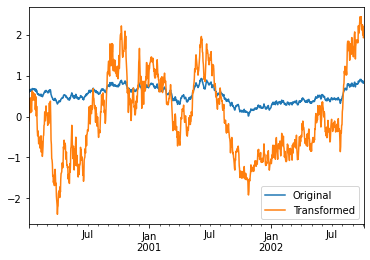

In [62]:
compare = pd.DataFrame({
    'Original':ts,
    'Transformed':transformed
})
compare.plot()

In [66]:
ts.groupby(lambda x: x.year).transform(lambda x: x.max() - x.min())

2000-01-08    0.581170
2000-01-09    0.581170
2000-01-10    0.581170
2000-01-11    0.581170
2000-01-12    0.581170
                ...   
2002-09-30    0.637862
2002-10-01    0.637862
2002-10-02    0.637862
2002-10-03    0.637862
2002-10-04    0.637862
Freq: D, Length: 1001, dtype: float64

In [70]:
max = ts.groupby(lambda x: x.year).transform('max')
min = ts.groupby(lambda x: x.year).transform('min')
max - min

2000-01-08    0.581170
2000-01-09    0.581170
2000-01-10    0.581170
2000-01-11    0.581170
2000-01-12    0.581170
                ...   
2002-09-30    0.637862
2002-10-01    0.637862
2002-10-02    0.637862
2002-10-03    0.637862
2002-10-04    0.637862
Freq: D, Length: 1001, dtype: float64

In [83]:
data_df = pd.DataFrame(np.random.randn(1000,3), columns=list('ABC'))
data_df[1:500] = np.nan
data_df

countries = np.array(['US', 'UK', 'GR', 'JP'])
key = countries[np.random.randint(0,4,1000)]
grouped = data_df.groupby(key)
grouped.count()

transformed = grouped.transform(lambda x: x.fillna(x.mean()))
transformed

,A,B,C
0,0.533388,-1.005767,0.010493
1,-0.038879,0.010177,-0.075068
2,-0.163673,-0.049789,0.121980
3,-0.038879,0.010177,-0.075068
4,-0.217335,-0.034799,-0.004809
...,...,...,...
995,-0.255271,-0.951633,1.687543
996,-0.499469,2.493994,1.110352
997,1.594732,0.954558,1.573561
998,-1.767205,-0.969199,0.632310


In [84]:
grouped_trans = transformed.groupby(key)
grouped.mean() # original group means

,A,B,C
GR,-0.217335,-0.034799,-0.004809
JP,-0.038879,0.010177,-0.075068
UK,-0.064048,0.063757,0.089282
US,-0.163673,-0.049789,0.121980


In [87]:
grouped_trans.mean()

grouped.count()
grouped_trans.count()

,A,B,C
GR,275,275,275
JP,276,276,276
UK,220,220,220
US,229,229,229


In [89]:
grouped.size()
grouped_trans.size()

GR    275
JP    276
UK    220
US    229
dtype: int64

In [96]:
df = pd.DataFrame({
    'a':[10,20,40,np.nan,50,60],
    'c':['UK','US','US','US','UK','US']
})

df.groupby('c').count()
	a
c	
UK	2
US	3

df.groupby('c').size()
c
UK    2
US    4

c
UK    2
US    4
dtype: int64

In [100]:
data_df
grouped.ffill()

,A,B,C
0,0.533388,-1.005767,0.010493
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,0.533388,-1.005767,0.010493
...,...,...,...
995,-0.255271,-0.951633,1.687543
996,-0.499469,2.493994,1.110352
997,1.594732,0.954558,1.573561
998,-1.767205,-0.969199,0.632310


In [109]:
df = DataFrame({
    'date' : pd.date_range('2017.01.01', periods=1000),
    'vol' : np.random.choice(100,1000)
})
df = df.set_index('date')
df.groupby(lambda x: x.year).transform('count')

,vol
date,
2017-01-01,365
2017-01-02,365
2017-01-03,365
2017-01-04,365
2017-01-05,365
...,...
2019-09-23,270
2019-09-24,270
2019-09-25,270


In [122]:
df_re = pd.DataFrame({
    'A':np.repeat([1,5],5),
    'B':np.arange(10)
})
df_re.groupby('A').rolling(4).B.mean()
df_re.groupby('A').expanding(4).B.mean()
df_re.groupby("A").expanding().sum()


A     B
A              
1 0   1.0   0.0
  1   2.0   1.0
  2   3.0   3.0
  3   4.0   6.0
  4   5.0  10.0
5 5   5.0   5.0
  6  10.0  11.0
  7  15.0  18.0
  8  20.0  26.0
  9  25.0  35.0

In [133]:
df_re = pd.DataFrame({
    "date": pd.date_range(start="2016-01-01", periods=4, freq="W"),
    "group": [1, 1, 2, 2],
    "val": [5, 6, 7, 8],
}).set_index("date")
df_re.groupby("group", as_index=False).resample('1D').ffill()

group  val
  date                  
0 2016-01-03      1    5
  2016-01-04      1    5
  2016-01-05      1    5
  2016-01-06      1    5
  2016-01-07      1    5
  2016-01-08      1    5
  2016-01-09      1    5
  2016-01-10      1    6
1 2016-01-17      2    7
  2016-01-18      2    7
  2016-01-19      2    7
  2016-01-20      2    7
  2016-01-21      2    7
  2016-01-22      2    7
  2016-01-23      2    7
  2016-01-24      2    8

In [13]:
sf = pd.Series([1, 1, 2, 2, 3, 3, 3])
print(sf.groupby(sf).groups)
sf.groupby(sf).filter(lambda x: x.sum() > 2)

{1: [0, 1], 2: [2, 3], 3: [4, 5, 6]}


2    2
3    2
4    3
5    3
6    3
dtype: int64

In [24]:
dff = pd.DataFrame({"AB": np.arange(8), "BC": list("aabbbbcc"),
                   "AC":np.arange(8)})
print(dff.groupby('B').groups)
dff.groupby('B').filter(lambda x:len(x) > 2, dropna=False)

{'a': [0, 1], 'b': [2, 3, 4, 5], 'c': [6, 7]}


,A,B
0,NaN,NaN
1,NaN,NaN
2,2.0,b
3,3.0,b
4,4.0,b
5,5.0,b
6,NaN,NaN
7,NaN,NaN


In [27]:
dff["C"] = np.arange(8)
dff.groupby('B', as_index=False).filter(lambda x: len(x.C) > 2)

,A,B,C
2,2,b,2
3,3,b,3
4,4,b,4
5,5,b,5


dff = pd.DataFrame({"AB": np.arange(8), "BC": list("aabbbbcc"),
                   "AC":np.arange(8), "EZ":np.arange(8)})
dff.filter(regex=('[A-C]'))

# 2.17.7 Dispatching to instance methods

In [37]:
df = pd.DataFrame({
    "A": ["foo", "bar", "foo", "bar", "foo", "bar", "foo", "foo"],
    "B": ["one", "one", "two", "three", "two", "two", "one", "three"],
    "C": np.random.randn(8),
    "D": np.random.randn(8),
})
grouped = df.groupby("A")
grouped.agg('std')
grouped.agg(lambda x: x.std())

,C,D
A,,
bar,0.962858,0.275274
foo,0.405855,1.056654


In [38]:
grouped.std()

,C,D
A,,
bar,0.962858,0.275274
foo,0.405855,1.056654


In [43]:
tsdf = pd.DataFrame(np.random.randn(1000, 3),
                    index=pd.date_range("1/1/2000", periods=1000),
                    columns=["A", "B", "C"],
                   )
tsdf.iloc[::2] = np.nan
grouped = tsdf.groupby(lambda x: x.year)
grouped.fillna(method='pad').bfill()

,A,B,C
2000-01-01,-0.184324,-0.450866,0.747624
2000-01-02,-0.184324,-0.450866,0.747624
2000-01-03,-0.184324,-0.450866,0.747624
2000-01-04,0.323290,0.581046,1.134165
2000-01-05,0.323290,0.581046,1.134165
...,...,...,...
2002-09-22,-0.815618,0.456963,0.371204
2002-09-23,-0.815618,0.456963,0.371204
2002-09-24,1.308077,-0.180499,0.380574
2002-09-25,1.308077,-0.180499,0.380574


In [49]:
s = pd.Series([9, 8, 7, 5, 19, 1, 4.2, 3.3])
g = pd.Series(list("abababab"))
gb = s.groupby(g)
gb.nlargest(2)
gb.nsmallest(2)

a  6    4.2
   2    7.0
b  5    1.0
   7    3.3
dtype: float64

# Flexible apply

In [4]:
df = pd.DataFrame({
    "A": ["foo", "bar", "foo", "bar", "foo", "bar", "foo", "foo"],
    "B": ["one", "one", "two", "three", "two", "two", "one", "three"],
    "C": np.random.randn(8),
    "D": np.random.randn(8),
})
grouped = df.groupby('A')

# could also just call .describe()
grouped.C.apply(lambda x: x.describe())

A         
bar  count    3.000000
     mean    -0.182456
     std      0.429934
     min     -0.674848
     25%     -0.332967
     50%      0.008913
     75%      0.063739
     max      0.118565
foo  count    5.000000
     mean     0.056627
     std      0.701117
     min     -0.958506
     25%     -0.266039
     50%      0.120826
     75%      0.602590
     max      0.784263
Name: C, dtype: float64

In [72]:
grouped = df.groupby('A').C

def f(group):
    print(group)
    return pd.DataFrame({
        'original':group, 
        'deamed':group - group.mean()
    })

grouped.apply(f)

1   -0.674848
3    0.008913
5    0.118565
Name: bar, dtype: float64
0   -0.266039
2   -0.958506
4    0.602590
6    0.120826
7    0.784263
Name: foo, dtype: float64


,original,deamed
0,-0.266039,-0.322665
1,-0.674848,-0.492392
2,-0.958506,-1.015133
3,0.008913,0.191370
4,0.602590,0.545963
5,0.118565,0.301022
6,0.120826,0.064200
7,0.784263,0.727636


In [77]:
def f(x):
    return pd.Series([x, x**2], index=["x", "x^2"])

def f1(x):
    return pd.Series(x, index=['x'])

s = pd.Series(np.random.rand(5))
s.apply(f)

# When we apply apply on a series, it returns df
s.apply(f1)

pandas.core.frame.DataFrame

In [97]:
from decimal import Decimal

df_dec = pd.DataFrame({
    'id':np.tile([1,2],2),
    'int_column':np.arange(1,5),
    'decimal_column':[Decimal('0.5'), Decimal('0.15'), 
                     Decimal('0.25'), Decimal('0.4')]
})
df_dec

# Decimal columns can be sum'd explicitly by themselves...
df_dec.groupby('id', as_index=False)[['decimal_column']].sum() 
df_dec.groupby('id', as_index=False).decimal_column.sum() 

# ...but cannot be combined with standard data types or they will be excluded
df_dec.groupby(["id"])[["int_column", "decimal_column"]].sum()

# Use .agg function to aggregate over standard and "nuisance" data types
# at the same time

df_dec.groupby(["id"]).agg({"int_column": "sum", "decimal_column": "sum"})

,int_column,decimal_column
id,,
1,4,0.75
2,6,0.55


In [103]:
s = (pd.Series([1, 1, 1]).groupby(
    pd.Categorical(np.repeat('a',3), categories=['a','b']), 
    observed=False).count())
s.index.dtype # CategoricalDtype(categories=['a', 'b'], ordered=False)

CategoricalDtype(categories=['a', 'b'], ordered=False)

In [112]:
df = pd.DataFrame({
    'a':[.2,.1,.5,.9]
})

pd.qcut(df.a, [0,.25,.5,.75, 1])

0     (0.175, 0.35]
1    (0.099, 0.175]
2       (0.35, 0.6]
3        (0.6, 0.9]
Name: a, dtype: category
Categories (4, interval[float64]): [(0.099, 0.175] < (0.175, 0.35] < (0.35, 0.6] < (0.6, 0.9]]

In [116]:
data = pd.Series(np.random.randn(100))
factor = pd.qcut(data, [0,.25,.5,.75, 1])
data.groupby(factor).mean()

(-2.266, -0.722]    -1.139450
(-0.722, -0.0579]   -0.433597
(-0.0579, 0.607]     0.232644
(0.607, 3.207]       1.410122
dtype: float64

In [117]:
import datetime
df = pd.DataFrame({
     "Branch": "A A A A A A A B".split(),
     "Buyer": "Carl Mark Carl Carl Joe Joe Joe Carl".split(),
     "Quantity": [1, 3, 5, 1, 8, 1, 9, 3],
     "Date": [
         datetime.datetime(2013, 1, 1, 13, 0),
         datetime.datetime(2013, 1, 1, 13, 5),
         datetime.datetime(2013, 10, 1, 20, 0),
         datetime.datetime(2013, 10, 2, 10, 0),
         datetime.datetime(2013, 10, 1, 20, 0),
         datetime.datetime(2013, 10, 2, 10, 0),
         datetime.datetime(2013, 12, 2, 12, 0),
         datetime.datetime(2013, 12, 2, 14, 0),
     ]
 })

df

,Branch,Buyer,Quantity,Date
0,A,Carl,1,2013-01-01 13:00:00
1,A,Mark,3,2013-01-01 13:05:00
2,A,Carl,5,2013-10-01 20:00:00
3,A,Carl,1,2013-10-02 10:00:00
4,A,Joe,8,2013-10-01 20:00:00
5,A,Joe,1,2013-10-02 10:00:00
6,A,Joe,9,2013-12-02 12:00:00
7,B,Carl,3,2013-12-02 14:00:00


In [118]:
df.groupby([pd.Grouper(freq='1M', key='Date'), "Buyer"]).sum()

Quantity
Date       Buyer          
2013-01-31 Carl          1
           Mark          3
2013-10-31 Carl          6
           Joe           9
2013-12-31 Carl          3
           Joe           9

In [121]:
df = df.set_index('Date')
df['Date'] = df.index + pd.offsets.MonthEnd(2)

## Column and Index have same name

## when we want to group by column
df.groupby([pd.Grouper(freq='6M', key='Date'), "Buyer"]).sum()

## when we want to group by index
df.groupby([pd.Grouper(freq='6M', level='Date'), "Buyer"]).sum()

Quantity
Date       Buyer          
2013-04-30 Carl          1
           Mark          3
2014-04-30 Carl          9
           Joe          18